<center><h1><u>Traitement de donnée HumanForYou</u></h1></center>

<br><br><br>

<center><font size="3"> Montet Thomas - Clerc Jules - Benard Kevin - Mehrenberger Maxime</font></center>
<center><font size="3"> CESI - Nice</font></center>
<center><font size="3"> 17 Mars 2022</font></center>

<br>

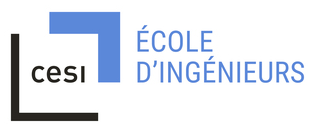

### Contexte

Une entreprise fait appel à nous, pour déterminer les facteurs ayant le plus d'influence sur ce taux de turn-over et lui proposer des modèles afin d'avoir des pistes d'amélioration pour donner à leurs employés l'envie de rester.


### Rappel des objectifs

- La génération de votre/vos jeux de données en justifiant les choix et les traitements effectués pour faire face aux problématiques classiques de ce type de travail.

- le choix de (des) l'algorithme(s) d'"IA" retenu(s).

- l'analyse des résultats obtenus et leur interprétation en s'appuyant sur des métriques.

- La démarche mise en œuvre pour améliorer un modèle.

- le choix du modèle retenu au final parmi les différents essais effectués en justifiant pas rapport au besoin de votre client et des métriques.

- vos propositions finales justifiées



### Liste des tâches

Avant de commencer, nous avons posé le problème et fait la liste des taches à réaliser pour avoir une compréhension globale et de s'organiser pour proposer une solution.<br>
Pour afficher la liste des tâche réalisées et à faire, on a utilisé le site en ligne "Trello".

Photo de la liste des tâches sur "Trello" :<br>
![taches](liste_tache.png)

### Préparation de l'environnement

Pour proposer une solution a ce problème, on commence donc a récupérer et traiter les données qui nous intéressent. On prépare donc l'environnement pour la suite du processus.

On possède de nombreuses données pour chaque employé dans l'entreprise et aussi s'il est parti l'année suivante.

#### Import et chargement

On commence par récupérer les données fournies par l'entreprise en format "csv" et les chargés.

In [1]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

OLD_DATA_PATH = os.path.join("datasets", "old data")

# Fonction pour charger les données
def load_hr_data(file, index):
    csv_path = os.path.join(OLD_DATA_PATH, file)
    if index is None:
        return pd.read_csv(csv_path)
    else:
        return pd.read_csv(csv_path, index_col=[0])

In [2]:
list_pd = {}

# On charge les données qui sont tous dans un dossier
for root,dirs,files in os.walk(OLD_DATA_PATH):
    for file in files:
        if file.endswith('.csv'):
            if 'time' in file:
                list_pd[file] = load_hr_data(file, 1)
            else:
                list_pd[file] = load_hr_data(file, None)
            print(file)

out_time.csv
employee_survey_data.csv
manager_survey_data.csv
in_time.csv
general_data.csv


#### Trier les données nécéssaires

Maintenant, qu'on a chargé les données les fichiers, on les traite pour qu'ils soient utilisables par la suite.<br>
On commence par les données d'entrée et de sorties de l'employé dans l'entreprise. Pour connaître le nombre de jours d'absence et le nombre d'heures en moyenne de travail par jour.

In [3]:
#On supprime les colonnes comportant que des NA, car elles correspondent à des jours où personne ne travaille.
list_pd['in_time.csv']  = list_pd['in_time.csv'].dropna(axis=1,how='all')
list_pd['out_time.csv'] = list_pd['out_time.csv'].dropna(axis=1,how='all')

In [4]:
#On remplace les cases manquantes par 0
list_pd['in_time.csv'].fillna(0,inplace=True)
list_pd['out_time.csv'].fillna(0,inplace=True)

In [5]:
#On change le type par datetime
list_pd['in_time.csv']  = list_pd['in_time.csv'].apply(pd.to_datetime, errors="raise")
list_pd['out_time.csv'] = list_pd['out_time.csv'].apply(pd.to_datetime, errors="raise")

In [6]:
#On détermine le temps de travail par jour
in_out_diff = pd.DataFrame()

cols=list_pd['in_time.csv'].columns
for col in cols:
    in_out_diff[col]=((pd.to_datetime(list_pd['out_time.csv'][col].astype(str)) - 
                             pd.to_datetime(list_pd['in_time.csv'][col].astype(str))).dt.total_seconds() / 3600.0)

In [7]:
#On ajoute deux colonnes absences_days et mean_actual_hours
in_out_diff['absences_days']     = (in_out_diff == 0).astype(int).sum(axis=1)
in_out_diff['mean_actual_hours'] = round(in_out_diff.astype(int).mean(axis=1),2)

On obtient donc sur le tableau ci-dessous, un tableau avec le nombre d'absences et le nombre d'heures de travail en moyenne pour chaque employé.

In [8]:
in_out_diff = in_out_diff[['absences_days','mean_actual_hours']]

in_out_diff.insert(0, 'EmployeeID', range(1, 1 + len(in_out_diff)))

in_out_diff # Tableau final des absences et du nombres d'heures de travail en moyenne

,EmployeeID,absences_days,mean_actual_hours
1,1,17,6.48
2,2,13,6.82
3,3,7,6.30
4,4,14,6.39
5,5,4,7.34
...,...,...,...
4406,4406,6,7.85
4407,4407,8,5.50
4408,4408,18,6.69
4409,4409,8,8.70


Maintenant, qu'on a notre tableau des absences et des heures de travail, on fusionne toutes les données pour obtenir un seul tableau pour facilité la suite du processus.

In [9]:
# On supprime les colonnes inutiles car ce sont des valeurs constantes et identiques
list_pd['general_data.csv'] = list_pd['general_data.csv'].drop(columns=['EmployeeCount', 'Over18', 'StandardHours'], axis=1)

In [10]:
# On fusionne tous les tableaux de données à l'aide de l'ID de l'employé pour n'en faire qu'un seul
from functools import reduce

data_frames = [list_pd['employee_survey_data.csv'], list_pd['manager_survey_data.csv'], list_pd['general_data.csv'], in_out_diff]

In [11]:
# Résultat de la fusion
df_merged   = reduce(lambda  left,right: pd.merge(left,right,on=['EmployeeID'], how='outer'), data_frames)

df_merged # Tableau final

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Age,Attrition,BusinessTravel,Department,...,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,absences_days,mean_actual_hours
0,1,3.0,4.0,2.0,3,3,51,No,Travel_Rarely,Sales,...,1.0,11,0,1.0,6,1,0,0,17,6.48
1,2,3.0,2.0,4.0,2,4,31,Yes,Travel_Frequently,Research & Development,...,0.0,23,1,6.0,3,5,1,4,13,6.82
2,3,2.0,2.0,1.0,3,3,32,No,Travel_Frequently,Research & Development,...,1.0,15,3,5.0,2,5,0,3,7,6.30
3,4,4.0,4.0,3.0,2,3,38,No,Non-Travel,Research & Development,...,3.0,11,3,13.0,5,8,7,5,14,6.39
4,5,4.0,1.0,3.0,3,3,32,No,Travel_Rarely,Research & Development,...,4.0,12,2,9.0,2,6,0,4,4,7.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,4406,4.0,1.0,3.0,3,3,42,No,Travel_Rarely,Research & Development,...,3.0,17,1,10.0,5,3,0,2,6,7.85
4406,4407,4.0,4.0,3.0,2,3,29,No,Travel_Rarely,Research & Development,...,2.0,15,0,10.0,2,3,0,2,8,5.50
4407,4408,1.0,3.0,3.0,3,4,25,No,Travel_Rarely,Research & Development,...,0.0,20,0,5.0,4,4,1,2,18,6.69
4408,4409,4.0,1.0,3.0,2,3,42,No,Travel_Rarely,Sales,...,0.0,14,1,10.0,2,9,7,8,8,8.70


Maintenant, que l'on a notre tableau final avec toutes les données, on va les "numériser", c'est-à-dire remplacer par des valeurs numériques toutes les données, pour pouvoir les utiliser dans les modèles qu'on aura choisis par la suite.

In [12]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

#On utilise l'encoder pour supprimer les valeurs non-numériques, chaque attribut devient désormais
#une colonne avec comme nouvel attribut 0 ou 1
listColumnsOneHotEncoder = ["BusinessTravel", "Department", "EducationField", "JobRole", "MaritalStatus"]
for column in listColumnsOneHotEncoder:
    cat_encoder_tmp = OneHotEncoder()
    tmp_encoded     = cat_encoder_tmp.fit_transform(df_merged[[column]])
    df_merged[cat_encoder_tmp.categories_[0]] = tmp_encoded.toarray()
df_merged = df_merged.drop(columns=listColumnsOneHotEncoder, axis=1)

#On utilise un encoder pour transformer une valeur non-numérique en valeur numérique
#Cette encoder est utilisé pour les colonnes ne possédant que deux attributs différents.
listColumnsOrdinalEncoder = ["Gender", "Attrition"]
for column in listColumnsOrdinalEncoder:
    cat_encoder_tmp   = OrdinalEncoder()
    tmp_encoded       = cat_encoder_tmp.fit_transform(df_merged[[column]])
    df_merged[column] = tmp_encoded

In [13]:
#Dans certaines colonnes possédant des valeurs manquantes, nous ajoutons la médiane dans les valeurs vides afin
#de ne pas trop altérer le poids de l'attribut
listColumnsMedians = ["EnvironmentSatisfaction", "JobSatisfaction", "WorkLifeBalance", "NumCompaniesWorked", "TotalWorkingYears"]
for column in listColumnsMedians:
    median = df_merged[column].median()
    df_merged[column].fillna(median, inplace=True) # option 3

#On vérifie qu'on ne possède plus aucune valeur vide
nb_NA = df_merged.columns[df_merged.isna().any()].tolist()
print("nombre de NA dans le dataframe:", len(nb_NA))

nombre de NA dans le dataframe: 0


In [14]:
# Tableau final utilisable par les modèles avec seulement des valeurs numériques
df_merged

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Age,Attrition,DistanceFromHome,Education,...,Laboratory Technician,Manager,Manufacturing Director,Research Director,Research Scientist,Sales Executive,Sales Representative,Divorced,Married,Single
0,1,3.0,4.0,2.0,3,3,51,0.0,6,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,3.0,2.0,4.0,2,4,31,1.0,10,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,3,2.0,2.0,1.0,3,3,32,0.0,17,4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,4,4.0,4.0,3.0,2,3,38,0.0,2,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,4.0,1.0,3.0,3,3,32,0.0,10,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,4406,4.0,1.0,3.0,3,3,42,0.0,5,4,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4406,4407,4.0,4.0,3.0,2,3,29,0.0,2,4,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4407,4408,1.0,3.0,3.0,3,4,25,0.0,25,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4408,4409,4.0,1.0,3.0,2,3,42,0.0,18,2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


On sauvegarde notre tableau final dans un "csv" si l'on veut le réutiliser sans réeffectuer les étapes précédentes.

In [15]:
NEW_DATA_PATH = os.path.join("datasets", "new data", "merged.csv")

df_merged.to_csv(NEW_DATA_PATH)

### Détermination du modèle

Actuellement, nos données sont prêtes et utilisables par des modèles. Maintenant, on va donc choisir et tester plusieurs modèles afin de trouver le modèle avec les meilleurs résultats.

In [16]:
# On commence donc par diviser nos données en plusieurs parties, pour l'entraînement et les tests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y_train = df_merged['Attrition']
X_train = df_merged.drop(['Attrition'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

Scaler_S = StandardScaler()

X_train  = Scaler_S.fit_transform(X_train)
X_test   = Scaler_S.transform(X_test)

Les deux blocs suivants sont des fonctions pour des graphes et des tableaux qu'on utilisera après les résultats obtenus de chaque modèle.

In [17]:
import matplotlib.pyplot as plt
import itertools

# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [18]:
# Les deux fonctions servent à colorer les tableaux en fonction des valeurs
def _color_red_or_green(val):
    color = 'red' if val < 0.90 else 'green'
    if val > 1:
        color = 'black' 
    return 'color: %s' % color

def highlight_90(s, props=''):
    return np.where(0.90 < s, props, '')

Maintenant, qu'on a séparé nos données pour l'entraînement et les tests, on peut utiliser des modèles.<br>
D'après les données et du problème que l'on veut résoudre, les modèles de "classification" sont ceux qui nous intéressent.<br>
Pour cela, on en a sélectionné trois différents que l'on va comparer entre eux, qui sont : "Logistic Regression", "Support Vector Classification" et "Random Forest Classifier".<br>
Pour effectuer ce choix, nous avons utilisé le schéma ci-dessous de sélection du modèle.

Carte du choix du modèle de Scikit Learn :
![Model](ml_map.png)

In [78]:
from sklearn.model_selection import learning_curve
def evaluation(name, model):    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                                cv=4, scoring='f1',
                                                 train_sizes=np.linspace(0.1, 1, 10))
    
    plt.figure(figsize=(10, 5))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    plt.title(name)
    plt.show()

NOM DU MODELE :  Logistic Regression 

RAPPORT PRÉDICTION :

tableau des statistiques des prédictions : 


,precision,recall,f1-score,Number of persons
stay in the company,0.867879,0.966262,0.914432,741.000000
leave the company,0.561404,0.226950,0.323232,141.000000
macro avg,0.714641,0.596606,0.618832,882.000000
weighted avg,0.818884,0.848073,0.819920,882.000000


tableau de la description du modèle : 


,Accuracy,Best Parameters,Cross-Validation,Process Time - second
Result,0.864512,"{'C': 0.1, 'penalty': 'l2'}",0.860262,2.8



 MATRICE DE CONFUSION :


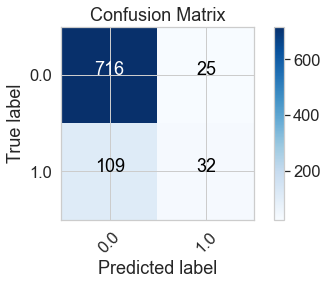

-----------------------------------------
NOM DU MODELE :  Support Vector Classification 

RAPPORT PRÉDICTION :

tableau des statistiques des prédictions : 


,precision,recall,f1-score,Number of persons
stay in the company,0.984043,0.998650,0.991293,741.000000
leave the company,0.992308,0.914894,0.952030,141.000000
macro avg,0.988175,0.956772,0.971661,882.000000
weighted avg,0.985364,0.985261,0.985016,882.000000


tableau de la description du modèle : 


,Accuracy,Best Parameters,Cross-Validation,Process Time - second
Result,0.995748,"{'C': 20, 'gamma': 0.01, 'kernel': 'rbf'}",0.965989,942.5



 MATRICE DE CONFUSION :


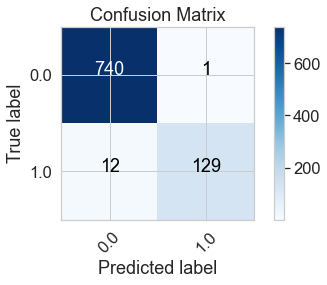

-----------------------------------------
NOM DU MODELE :  Random Forest Classifier 

RAPPORT PRÉDICTION :

tableau des statistiques des prédictions : 


,precision,recall,f1-score,Number of persons
stay in the company,0.957364,1.000000,0.978218,741.000000
leave the company,1.000000,0.765957,0.867470,141.000000
macro avg,0.978682,0.882979,0.922844,882.000000
weighted avg,0.964180,0.962585,0.960513,882.000000


tableau de la description du modèle : 


,Accuracy,Best Parameters,Cross-Validation,Process Time - second
Result,0.994615,"{'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 500}",0.946713,1664.4



 MATRICE DE CONFUSION :


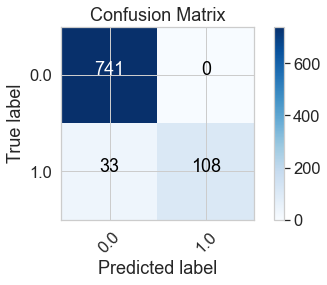

-----------------------------------------


In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import (confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, 
                                     classification_report, f1_score, average_precision_score, precision_recall_fscore_support)
from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import time


# On liste tous les modèles avec leurs paramètres que l'on veut tester
dict_of_models = [
                  ('Logistic Regression', LogisticRegression(random_state=42), {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}),
                  ('Support Vector Classification', SVC(random_state=42), {'C':[1,5,10,15,20],'gamma':[1,0.2,0.01,0.005], 'kernel':['linear','rbf']}),
                  ('Random Forest Classifier', RandomForestClassifier(random_state=42), {'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [7,8,10,12],'criterion' :['gini', 'entropy']})
                 ]

# On stockera nos données pour effectuer des graphes
box_plot      = []
graph         = []
model_trained = {}

# On effectue une boucle pour chaque modèle
for name, model, grid in dict_of_models:

    # MODELE
    print("NOM DU MODELE : ", name, '\n')
    

    start         =  time.time()                     # On lance un timer pour connaître la durée de l'algorithme
    model_cv      =  GridSearchCV(model, grid, cv=5) # On obtient le meilleur paramètre pour le modèle

    model_cv.fit(X_train,y_train)                    # On entraîne le modèle avec nos données

    prediction          =  model_cv.predict(X_test)  # On effectue les prédictions avec le modèle entraîné
    model_trained[name] =  model_cv                  # On stocke le modèle
    
    # DONNEES
    # On récupère toutes les données générées par le modèle
    report        =  classification_report(y_test, prediction, output_dict=True)
    best_param    =  model_cv.best_params_
    best_score    =  model_cv.best_score_
    score         =  model_cv.score(X_train,y_train)
    cross_val     =  cross_val_score(model_cv, X_train, y_train, cv=5, scoring="accuracy")

    end           =  time.time()               # Fin du timer pour connaître la durée de l'algorithme
    total_time    =  format(round(end-start,1))

    # Premier tableau des statistiques des prédictions
    first_report   = pd.DataFrame(report).transpose()
    first_report   = first_report.rename(columns={"support":"Number of persons"}, index={'0.0': 'stay in the company', '1.0': 'leave the company'})
    first_report   = first_report.drop("accuracy")
    first_report_c = first_report.style.applymap(_color_red_or_green, subset=pd.IndexSlice[:, ['precision', 'recall', 'f1-score']])
    first_report_c.apply(highlight_90, props='background-color: #e6ffe6;', subset=pd.IndexSlice[:, ['precision', 'recall', 'f1-score']], axis=0)

    # Deuxième tableau de la description du modèle
    second_report    = pd.DataFrame([[score, best_param, cross_val.mean(), total_time]], columns=['Accuracy','Best Parameters','Cross-Validation', 'Process Time - second'], index=['Result'])
    second_report_c  = second_report.style.applymap(_color_red_or_green, subset=pd.IndexSlice[:, ['Accuracy', 'Cross-Validation']])
    second_report_c.apply(highlight_90, props='background-color: #e6ffe6;', subset=pd.IndexSlice[:, ['Accuracy', 'Cross-Validation']], axis=0)
    
    # MATRICE DE CONFUSION
    class_names = y_test.unique()
    cm          = confusion_matrix(y_test, prediction)
    
    # GRAPHES
    fpr, tpr, thresholds   =  roc_curve(y_test, prediction)
    roc_auc                =  auc(fpr, tpr)
    precision, recall, th  =  precision_recall_curve(y_test, prediction)
    
    graph.append([fpr, tpr, thresholds, roc_auc, precision, recall, th])
    box_plot.append([name,cross_val])

    print("RAPPORT PRÉDICTION :\n")
    print("tableau des statistiques des prédictions : ")
    display(first_report_c)
    print("tableau de la description du modèle : ")
    display(second_report_c)
    print("\n MATRICE DE CONFUSION :")
    plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')
    print('-----------------------------------------')

<b>Descriptions des paramètres des deux tableaux :</b><br>

Premier tableau :
 - precision : <em>permet de mesurer le coût des faux positifs, c’est-à-dire ceux détectés par erreur</em> 
 - recall : <em>permet d’estimer combien de réels positifs sont réussis à capturer et combien sont passés au travers des mailles du filet</em>
 - f1-score : <em>ratio de la precision sur le recall</em>
 - number of persons : <em>nombre de personnes qui sont négatives ou positives</em>
 - stay in the company : <em>prédictions sur les personnes qui restent dans l'entreprise</em>
 - leave the company : <em>predictions sur les personnes qui partent de l'entreprise</em>
 - macro avg : <em>moyenne sans compter le poids (sans compter que des données sont plus importantes que d'autres)</em>
 - weighted avg : <em>moyenne en comptant le poids (sans compter que des données sont plus importantes que d'autres)</em>


Deuxième tableau :
 - accuracy : <em>permet de connaître la proportion de bonnes prédictions par rapport à toutes les prédictions</em>
 - best parameters : <em>meilleure combinaison de paramètres pour notre modèle </em>
 - cross-validation : <em>on sépare nos données d’entraînement pour vérifier si notre modèle est constant et ne possède pas de problème ou d'erreur</em>
 - process time - second : <em>temps d'exécution de l'algorithme en seconde</em>

On peut voir grâce aux tableaux et aux matrices de chaque modèle, ci-dessus, leurs différentes statistiques. D'après ce que l'on peut voir le modèle "Support Vector Classification" possède de meilleur statistique.<br>
On va donc comparer tous les modèles avec des graphes maintenant pour valider le modèle que l'on gardera.

<b>On vérifie maintenant si nos modèles sont en sur-apprentissage ou en sous-apprentissage.
Pour ça, on utilise "la courbe d'apprentissage".</b><br>
Dans les cas de tous nos modèles, ci-dessous, on peut constater que nous ne sommes ni en sur-apprentissage et ni en sous-apprentissage.<br>
Nos modèles ne possèdent pas de problème, car nos courbes de "train" et de "validation" se rapprochent et que l'écart entre elle reste constant.

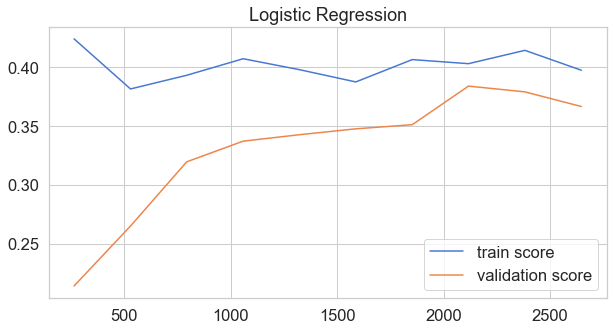

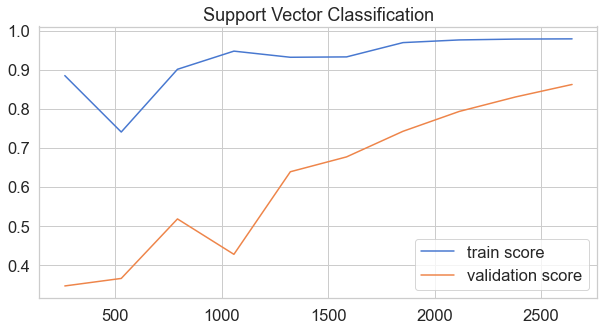

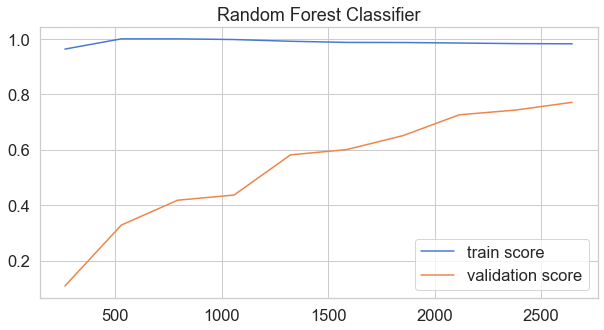

In [79]:
for model in model_trained:
    evaluation(model, model_trained[model])

#### Graph - Boite à moustache

Avec cette boite à moustache, ci-dessous, on peut voir la variation de la justesse des différents modèles. <br>
Moins elle a de variation et plus la valeur est élevé, le mieux est notre modèle.<br>
Dans le cas ci-dessous, le modèle "Support Vector Classification" possède les meilleurs résultats.

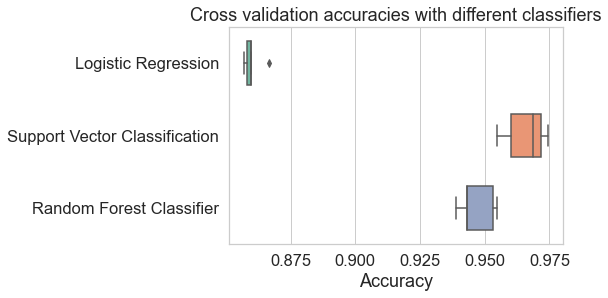

In [20]:
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

accuracy_test = []

accuracy_test.append(box_plot[0][1])
accuracy_test.append(box_plot[1][1])
accuracy_test.append(box_plot[2][1])


box   = pd.DataFrame(accuracy_test, index=['Logistic Regression', 'Support Vector Classification', 'Random Forest Classifier'])
boxT  = box.T
ax    = sns.boxplot(data=boxT, orient="h", palette="Set2", width=.6)
ax.set_yticklabels(['Logistic Regression', 'Support Vector Classification', 'Random Forest Classifier'])
ax.set_title('Cross validation accuracies with different classifiers')
ax.set_xlabel('Accuracy')
plt.show()

#### Graphe - ROC

Avec ce graphe, on peut voir les performances des trois algorithmes, en représentant les réponses justes. Plus le modèle se rapproche de 1 sur les deux axes, plus il est performant.<br>
Dans le cas ci-dessous, le modèle "Support Vector Classification" possède les meilleurs résultats.

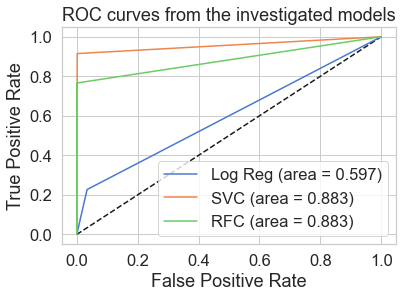

In [21]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(graph[0][0], graph[0][1], label='Log Reg (area = %0.3f)' % graph[0][3])
plt.plot(graph[1][0], graph[1][1], label='SVC (area = %0.3f)' % graph[2][3])
plt.plot(graph[2][0], graph[2][1], label='RFC (area = %0.3f)' % graph[2][3])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves from the investigated models')
plt.legend(loc='best')
plt.show()

#### Graphe - Precision vs Recall

Avec ce graphe, on peut voir la différence entre la précision et le recall. Plus le modèle se rapproche de 1 sur les deux axes, plus il est performant. <br>
Dans le cas ci-dessous, le modèle "Support Vector Classification" possède les meilleurs résultats.

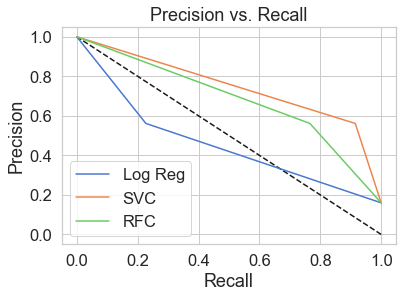

In [22]:
plt.plot([1, 0], [0, 1], 'k--')
plt.plot(graph[0][5], graph[0][4], label='Log Reg')
plt.plot(graph[1][5], graph[0][4], label='SVC')
plt.plot(graph[2][5], graph[0][4], label='RFC')
plt.title('Precision vs. Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

<b>D'après toutes les données analysées précédemment, on peut constater que le meilleur modèle pour notre problème est donc "Support Vector Classification".</b>

### Solution

Maintenant que nous avons choisi le meilleur modèle, nous allons essayer des solutions afin de baisser le taux de turn-over au sein de l'entreprise.

In [23]:
# Prépare le jeu de données pour le modèle
def createDataset(D):
    Scaler_S = StandardScaler()
    D        = Scaler_S.fit_transform(D)
    return D

D          = createDataset(df_merged.drop(['Attrition'],axis=1))
best_model = model_trained['Support Vector Classification']

In [24]:
result = best_model.predict(D)

In [25]:
from collections import Counter

def percentageOfAttrition(result):
    collections_result = Counter(result)
    print('percentage of attrition:', round((collections_result.get(1)/D.shape[0])*100,2), '%')
    
percentageOfAttrition(result)

percentage of attrition: 15.51 %


Actuellement, le taux de turn-over est d'environ 16%, nous devons essayer de modifier certains paramètres afin de faire chuter ce taux. Nous cherchons à déterminer par la matrice de corrélation, les paramètres que nous pourrions faire varier.

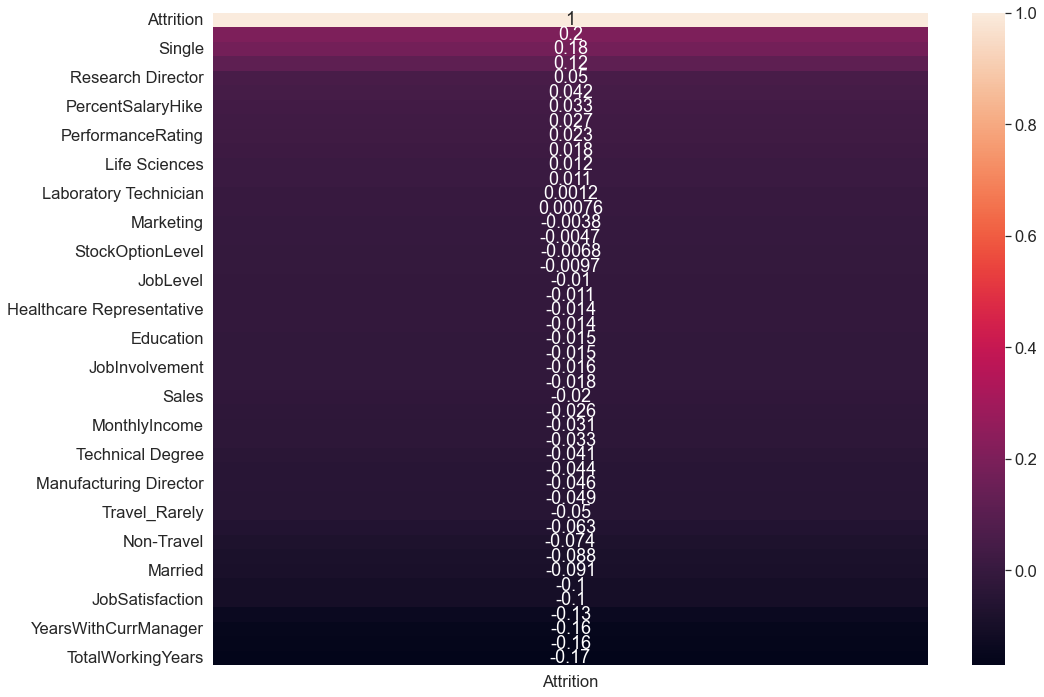

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
sns.heatmap(df_merged.corr()[['Attrition']].sort_values(by=['Attrition'], ascending=False), annot=True)
plt.show()

In [27]:
D = df_merged.drop(['Attrition'],axis=1)
D['prediction_attrition'] = result

#### étude de "mean_actual_hours"

In [28]:
mean_actual_hours = D.groupby('prediction_attrition').mean()['mean_actual_hours']
print('Une personne quittant l\'entreprise travaille', round(mean_actual_hours[1],1), 'heures contre', round(mean_actual_hours[0],1), 'pour les autres.')

Une personne quittant l'entreprise travaille 7.5 heures contre 6.7 pour les autres.


Leurs départs peut être expliqués par le fait qu'ils travaillent trop.

#### étude de "Single"

In [29]:
single = D.groupby(['prediction_attrition','Single']).size()

print(
    round((single[1,1]/(single[1,1]+single[1,0])) * 100,1),
    '% des personnes qui partent de l\'entreprise sont célibataires contre',
    round((single[0,1]/(single[0,1]+single[0,0])) * 100,1),
    '% pour les personnes restants dans l\'entreprise'
)

51.5 % des personnes qui partent de l'entreprise sont célibataires contre 28.4 % pour les personnes restants dans l'entreprise


Les célibataires ont donc plus de chance de quitter l'entreprise.

#### étude de "travel_frequently"

In [30]:
travel_frequently = D.groupby(['prediction_attrition','Travel_Frequently']).size()

travel_frequently

print(
    round((travel_frequently[1,1]/(travel_frequently[1,1]+travel_frequently[1,0])) * 100,1),
    '% des personnes qui partent de l\'entreprise voyagent fréquemment contre',
    round((travel_frequently[0,1]/(travel_frequently[0,1]+travel_frequently[0,0])) * 100,1),
    '% pour les personnes restants dans l\'entreprise'
)

29.5 % des personnes qui partent de l'entreprise voyagent fréquemment contre 16.9 % pour les personnes restants dans l'entreprise


Les personnes quittant l'entreprise ont tendance à voyager plus fréquemment.

#### étude de "years_with_current_manager"

In [31]:
years_with_current_manager = D.groupby('prediction_attrition').mean()['YearsWithCurrManager']
print('Une personne quittant l\'entreprise travaille avec son manager depuis environ', round(years_with_current_manager[1],1), 'ans contre', round(years_with_current_manager[0],1), 'pour les autres.')

Une personne quittant l'entreprise travaille avec son manager depuis environ 2.8 ans contre 4.4 pour les autres.


Les employés démissionant passent moins de temps avec leurs managers.

#### étude de "environment_satisfaction" & "job_satisfaction"

In [32]:
environment_satisfaction = D.groupby('prediction_attrition').mean()['EnvironmentSatisfaction']
print('Une personne quittant l\'entreprise a une satisfaction moyenne de', round(environment_satisfaction[1],1), '/5 contre', round(environment_satisfaction[0],1), 'pour les autres.')

Une personne quittant l'entreprise a une satisfaction moyenne de 2.5 /5 contre 2.8 pour les autres.


In [33]:
job_satisfaction = D.groupby('prediction_attrition').mean()['JobSatisfaction']
print('Une personne quittant l\'entreprise a une satisfaction moyenne de', round(job_satisfaction[1],1), '/5 contre', round(job_satisfaction[0],1), 'pour les autres.')

Une personne quittant l'entreprise a une satisfaction moyenne de 2.5 /5 contre 2.8 pour les autres.


#### étude de "Age"

In [34]:
age = D.groupby('prediction_attrition').mean()['Age']
print('Une personne quittant l\'entreprise a en moyenne', round(age[1],1), 'ans contre', round(age[0],1), 'pour les autres.')

Une personne quittant l'entreprise a en moyenne 33.5 ans contre 37.5 pour les autres.


Les personnes quitant l'entreprise sont plutôt de jeunes employés.

#### Hypothèse

D'après ces statistiques on peut émettre une hypothèse :

Les personnes quitants l'entreprise sont souvent de jeunes célibataires travaillant beaucoup, voyageant fréquemment et par conséquent sont moins intégrées au sein de l'entreprise. Ce qui peut expliquer les notes de satisfactions plus faibles que la moyenne. Nous essayons de modifier certains paramètres pour changer le taux de turn-over.

On réduit le temps de travail des personnes souhaitant partir d'une heure.

In [35]:
D['mean_actual_hours'] = np.where(D['prediction_attrition']==1, D['mean_actual_hours']-1, D['mean_actual_hours'])

Proposer des activités pour augmenter le taux de satisfaction, on suppose que chaque employé revoit à la hausse sa note d'un point supplémentaire.

In [36]:
D['EnvironmentSatisfaction'] = np.where(D['prediction_attrition']==1, D['EnvironmentSatisfaction']+1, D['EnvironmentSatisfaction'])
D['JobSatisfaction'] = np.where(D['prediction_attrition']==1, D['JobSatisfaction']+1, D['JobSatisfaction'])

On diminue le nombre de voyages professionnels, pour que les employés ne voyagent pas trop fréquemment.

In [37]:
D['Travel_Frequently'] = np.where(D['prediction_attrition']==1, 0, D['Travel_Frequently'])
D['Travel_Rarely'] = np.where(D['prediction_attrition']==1, 0, D['Travel_Rarely'])

Cette étape est un peu plus complexe, mais nous cherchons à faire varier le taux de personne célibataire. Ce taux pourrait par exemple être baisser par des speed-datings, ou simplement des activités pour réunir des personnes.

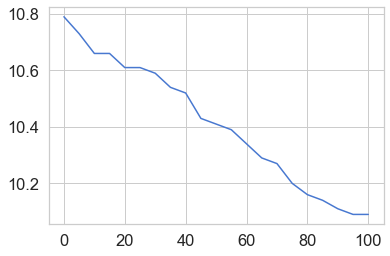

In [38]:
def predictSingle(percentage, data):
    newColumnSingle = []
    newColumnMarried = []
    countSingleChange = 0
    countMaxSingleChange = single[1,1] * percentage
    for index, row in data.iterrows():
        if(row['Single'] == 0 and row['prediction_attrition'] == 1 and countSingleChange < countMaxSingleChange):
            newColumnSingle.append(0)
            newColumnMarried.append(1)
            countSingleChange  = countSingleChange + 1
        else:
            newColumnSingle.append(row['Single'])
            newColumnMarried.append(row['Married'])
    data['Single'] = newColumnSingle
    data['Married'] = newColumnMarried
    dataset = createDataset(data.drop(['prediction_attrition'],axis=1))
    result = best_model.predict(dataset)
    collections_result = Counter(result)
    percentage = round((collections_result.get(1)/data.shape[0])*100,2)
    return(percentage)

resultPercentage = []
for i in range(0,101,5):
    resultPercentage.append(predictSingle(i/100, D.copy()))
plt.plot(range(0,101,5), resultPercentage)
plt.show()

En supposant que l'on arrive à faire baisser le taux de célibat d'environ 25%, notre taux de départ serait désormais de 13%, contre 16% au préalable.

D'autres facteurs sont malheuresement aussi à prendre en compte comme l'âge de la personne.

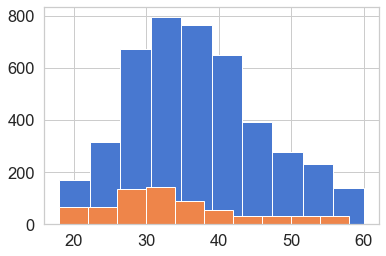

In [39]:
plt.hist(D.Age, bins=10)
plt.hist(D.Age[D['prediction_attrition'] == 1], bins=10)
plt.show()

Il s'agit principalement d'un problème chez les jeunes (18-30 disons)

In [40]:
#Combien de personne de moins de 30ans on quitté l'entreprise ?
countOver25Attrition = D.loc[(D['prediction_attrition'] == 1) & (D['Age'] < 31)]
nbAttrition = D.loc[(D['prediction_attrition'] == 1)].shape[0]
print(
    countOver25Attrition.shape[0], 
    "personnes de moins de 30 ans ont quitté l'entreprise, cela représente", 
    round(countOver25Attrition.shape[0] / nbAttrition, 1) * 100,
    "% des turn-over."
)

#Les moins de 30ans représentent quel proportion de l'entreprise ?
countOver25 = D.loc[(D['Age'] < 31)]
nbPersons = D.shape[0]
print(
    "Les personnes de moins de 30 ans représentent",
    round(countOver25.shape[0] / nbPersons, 1) * 100,
    "% des personnes de l'entreprise."
)

289 personnes de moins de 30 ans ont quitté l'entreprise, cela représente 40.0 % des turn-over.
Les personnes de moins de 30 ans représentent 30.0 % des personnes de l'entreprise.


### Conclusion

Suite à la demande de l'entreprise, nous avons donc commencé par faire la liste des tâches effectuées sur le site et réparties par personnes. <br>
On a ensuite traité les données, puis nous avons déterminé les modèles que nous voulons essayer, pour ensuite, choisir le modèle qu'on sélectionnera. <br>
Pour finir, on a proposé une solution au problème qui permettrait de réduire le nombre de personnes qui partent dans l'entreprise.